In [12]:
import pandas as pd
import os
from tqdm import tqdm
from urllib.request import urlretrieve
from multiprocessing import Pool
import torch
import clip
import os
from PIL import Image
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
from scipy.spatial import distance

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-diino1jy
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-diino1jy
  Using cached ftfy-6.0.3-py3-none-any.whl
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369067 sha256=f093608e1839bf4c1576623277ba42c40e3c4ade17fd2a4b49e4d46c36f71971
  Stored in directory: /tmp/pip-ephem-wheel-cache-m0mp7tfp/wheels/41/36/e0/af6191bd08c254b17d779b05de8282c9ea81ef7048abbe290b
Successfully built clip
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


### download

In [3]:
def download_image(x):
    if not os.path.exists('./evaluation'):
        os.mkdir('./evaluation')

    filename = os.path.join('./evaluation', x.split('/')[-1])
    if not os.path.exists(filename):
        try:
            urlretrieve(x, filename)
        except Exception as e:
            print(x, e)

In [4]:
evaluation_data = pd.read_csv('./EvaluationSample.csv')
# download images folder1
images = evaluation_data['url1'].tolist()
with Pool(20) as p:
    print(list((tqdm(p.imap(download_image, images), total=len(images), desc='监视进度'))))

images = evaluation_data['url2'].tolist()
with Pool(20) as p:
    print(list((tqdm(p.imap(download_image, images), total=len(images), desc='监视进度'))))

evaluation_data['filename1'] = evaluation_data['url1'].apply(lambda x: x.split('/')[-1])
evaluation_data['filename2'] = evaluation_data['url2'].apply(lambda x: x.split('/')[-1])

监视进度: 100%|██████████| 1000/1000 [00:00<00:00, 17469.42it/s]

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non


监视进度: 100%|██████████| 1000/1000 [00:00<00:00, 21912.21it/s]

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [5]:
evaluation_data.head()

,url1,url2,label,filename1,filename2
0,"https://image.xiaozhustatic1.com/00,800,533/1,...",https://pic.tujia.com/upload/cunit/day_200325/...,1,"1,19,0,93,10105,1124,750,ab76f566.jpg",202003250350513423_700_467.jpeg
1,"https://image.xiaozhustatic1.com/00,800,532/1,...",https://pic.tujia.com/upload/cunit/day_200325/...,1,"1,19,0,18,8193,1126,750,380e8003.jpg",202003250351024163_700_467.jpeg
2,"https://image.xiaozhustatic1.com/00,800,533/s,...",https://pic.tujia.com/upload/landlordunit/day_...,1,"s,1,BMwm,998,666,2,31966013.jpg",202005252247514917_700_467.jpg
3,"https://image.xiaozhustatic1.com/00,800,533/s,...",https://pic.tujia.com/upload/landlordunit/day_...,1,"s,1,BMwo,998,666,2,0043afce.jpg",202005252247521424_700_467.jpg
4,"https://image.xiaozhustatic1.com/00,800,600/s,...",https://pic.tujia.com/upload/landlordunit/day_...,1,"s,1,s6EQ,1000,750,2,24d49b15.jpg",202004192324001833_700_467.jpg


### directly zero-shot

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_clip_embedding(para1):
    image_path = os.path.join('./evaluation',para1)
    image_feature = model.encode_image(preprocess(Image.open(image_path)).unsqueeze(0).to(device))
    image_feature = (image_feature / image_feature.norm(dim=-1, keepdim=True)).cpu().detach().numpy()
    return image_feature
    
def clip_distance(para1,para2):
    hash1 = get_clip_embedding(para1)
    hash2 = get_clip_embedding(para2)
    n1 = distance.cosine(hash1, hash2)
    return n1

In [29]:
evaluation_data['similarity'] = 1-evaluation_data.apply(lambda x: clip_distance(x['filename1'], x['filename2']), axis=1)

In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_score, recall_score

def draw_roc(test_Y, pred):
    fpr, tpr, thresholds = roc_curve(test_Y, pred, pos_label=1)
    #print('fpr:', fpr)
    #print('tpr:', tpr)
    #print('thresholds:', thresholds)
    auc_score = auc(fpr, tpr)
    print('auc:', auc_score)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def p_r_f1(test_Y, pred, thres=0.5, pos_label=1):
    pred = [p>=thres and 1 or 0 for p in pred]
    cm = confusion_matrix(test_Y, pred)
    print(cm)
    precision = precision_score(test_Y, pred, pos_label=pos_label)
    print('precision:', precision)
    recall = recall_score(test_Y, pred, pos_label=pos_label)
    print('recall:', recall)
    f1 = f1_score(test_Y, pred, pos_label=pos_label)
    print('f1_score:', f1)

auc: 0.7247407643613002


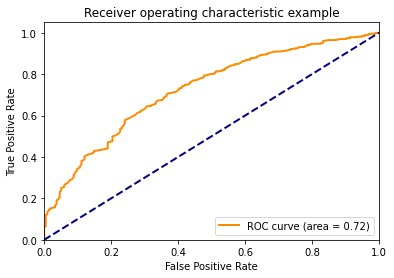

[[216   0]
 [746  38]]
precision: 1.0
recall: 0.04846938775510204
f1_score: 0.0924574209245742
[[193  23]
 [510 274]]
precision: 0.9225589225589226
recall: 0.3494897959183674
f1_score: 0.5069380203515264
[[ 89 127]
 [113 671]]
precision: 0.8408521303258145
recall: 0.8558673469387755
f1_score: 0.8482932996207333
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435
[[  0 216]
 [  0 784]]
precision: 0.784
recall: 1.0
f1_score: 0.8789237668161435


In [33]:
target = evaluation_data['label'].values
pred = evaluation_data['similarity'].values
draw_roc(target, pred)
p_r_f1(target, pred, thres=0.98)
p_r_f1(target, pred, thres=0.95)
p_r_f1(target, pred, thres=0.9)
p_r_f1(target, pred, thres=0.8)
p_r_f1(target, pred, thres=0.7)
p_r_f1(target, pred, thres=0.6)
p_r_f1(target, pred)
p_r_f1(target, pred, thres=0.4)
p_r_f1(target, pred, thres=0.3)

## clip one shot - logistic regressor

In [66]:
def get_clip_embedding(para1):
    image_path = os.path.join('./evaluation',para1)
    image_feature = model.encode_image(preprocess(Image.open(image_path)).unsqueeze(0).to(device))
    image_feature = (image_feature / image_feature.norm(dim=-1, keepdim=True)).cpu().detach().numpy()
    return image_feature

In [71]:
all_features = []
all_labels = []

for i in tqdm(range(len(evaluation_data))):
    a1 = get_clip_embedding(evaluation_data['filename1'][i])
    a2 = get_clip_embedding(evaluation_data['filename2'][i])
    features = np.concatenate((a1,a2),axis=1)
    labels = evaluation_data['label'][i]
    
    all_features.append(features)
    all_labels.append(labels)

100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


In [83]:
all_feature = np.array(all_features).reshape([1000,1024])
all_label = np.array(all_labels)

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.33, random_state=42)

In [97]:
from sklearn.linear_model import LogisticRegression

#train_feature, train_label = torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=2000, verbose=1)
classifier.fit(X_train, y_train)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(X_train)
accuracy = np.mean((y_train == predictions).astype(np.float)) * 100.
print(f"train Accuracy = {accuracy:.3f}")

# Evaluate using the logistic regression classifier
predictions = classifier.predict(X_test)
accuracy = np.mean((y_test == predictions).astype(np.float)) * 100.
print(f"val Accuracy = {accuracy:.3f}")


train Accuracy = 78.507
val Accuracy = 78.182


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [96]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[  0  72]
 [  0 258]]


## clip oneshot -lightgbm

In [99]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 4.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [110]:

import lightgbm as lgb

print('Starting training...')
# 模型训练
gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=1000, max_depth=5,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test),(X_train,y_train)], verbose=True, eval_metric=['auc'],
        early_stopping_rounds=5)


Starting training...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[1]	training's auc: 0.836568	training's binary_logloss: 0.490555	valid_0's auc: 0.666828	valid_0's binary_logloss: 0.51115
Training until validation scores don't improve for 5 rounds
[2]	training's auc: 0.928443	training's binary_logloss: 0.457057	valid_0's auc: 0.723137	valid_0's binary_logloss: 0.500485
[3]	training's auc: 0.968275	training's binary_logloss: 0.427813	valid_0's auc: 0.742786	valid_0's binary_logloss: 0.488744
[4]	training's auc: 0.970011	training's binary_logloss: 0.405733	valid_0's auc: 0.753876	valid_0's binary_logloss: 0.4804
[5]	training's auc: 0.985464	training's binary_logloss: 0.379626	valid_0's auc: 0.768519	valid_0's binary_logloss: 0.471182
[6]	training's auc: 0.991141	training's binary_logloss: 0.359

LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9, max_depth=5,
               n_estimators=1000, num_leaves=50, objective='binary',
               reg_lambda=0.2)

In [111]:
# Evaluate using the logistic regression classifier
predictions = gbm.predict(X_test)
accuracy = np.mean((y_test == predictions).astype(np.float)) * 100.
print(f"val Accuracy = {accuracy:.3f}")

val Accuracy = 81.515


In [112]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[ 11  61]
 [  0 258]]
